In [17]:
import torch
import torch.nn as nn
import numpy as np
from torch.optim import Optimizer

class DAM(Optimizer):
    """
    Directional-Adaptive Momentum (DAM) Optimizer

    Args:
        params (iterable): 待优化参数或参数字典
        lr (float, optional): 学习率 (默认: 1e-3)
        rank (int, optional): 低秩曲率矩阵的秩 (默认: 5)
        epsilon (float, optional): Hessian估计的扰动大小 (默认: 1e-2)
        lambda_ (float, optional): 曲率敏感系数 (默认: 0.1)
        delta (float, optional): 数值稳定性常数 (默认: 1e-6)
        min_eig (float, optional): 最小特征值 (默认: 1e-4)
        gamma (float, optional): 动量缩放因子 (默认: 100)
        beta (float, optional): 动量衰减系数 (默认: 0.9)
        closure (callable, optional): 可选的闭包函数，用于计算损失和梯度
        c (float, optional): 动量更新的缩放因子 (默认: 0.01)
        threshold (float, optional): clipping的阈值系数 (默认: 0.1)
    """
    def __init__(self, params, lr=1e-3, rank=10, epsilon=5e-2, lambda_base=0.001, 
                 delta=1e-6, min_eig=1e-4, gamma=200, beta=0.5, c=0.01, threshold=0.1):
        # 注意: 这里的key必须和后续group['xxx']一致
        defaults = dict(lr=lr, rank=rank, epsilon=epsilon, lambda_base=lambda_base,
                       delta=delta, min_eig=min_eig, gamma=gamma, beta=beta, c=c, threshold=threshold)
        super(DAM, self).__init__(params, defaults)
        
        self.step_count = 0
        self.gamma = gamma

    def step(self, closure=None):
        self.step_count += 1
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                grad = p.grad.data
                state = self.state[p]

                # 初始化状态
                if len(state) == 0:
                    d = p.data.numel()
                    k = group['rank']
                    V = torch.randn(d, k, device=p.device)
                    state.update({
                        'V': torch.linalg.qr(V)[0] * 0.01,
                        'Lambda': torch.eye(k, device=p.device),
                        'momentum': torch.zeros_like(p.data),
                        'prev_grad': torch.zeros_like(p.data),
                        'Hv_ema': None
                    })

                # 曲率估计
                with torch.no_grad():
                    v = torch.randn_like(p.data).view(-1)
                    v = v / (v.norm() + 1e-8)

                    p.data.add_(group['epsilon'] * v.view_as(p.data))
                    perturbed_grad = self._get_grad(p)
                    p.data.sub_(group['epsilon'] * v.view_as(p.data))

                    Hv = (perturbed_grad.view(-1) - state['prev_grad'].view(-1)) / (group['epsilon'] + 1e-8)
                    if state['Hv_ema'] is not None:
                        Hv = group['beta'] * state['Hv_ema'] + (1 - group['beta']) * Hv
                    state['Hv_ema'] = Hv.detach().clone()

                # 低秩更新
                with torch.no_grad():
                    V, Lambda = state['V'], state['Lambda']
                    v_t = V.T @ Hv

                    Lambda.add_(torch.outer(v_t, v_t) + group['min_eig'] * torch.eye(Lambda.size(0), device=Lambda.device))
                    inv_Lambda = torch.linalg.pinv(Lambda)

                    temp = Hv.view(-1, 1) - V @ v_t.view(-1, 1)
                    update = temp @ (v_t.view(1, -1) @ inv_Lambda)
                    update = update * (torch.norm(update, dim=0).clamp_max(1.0) / (torch.norm(update, dim=0) + 1e-8)).view(1, -1)
                    V.add_(update)

                # 参数更新
                with torch.no_grad():
                    diag_C = (V ** 2) @ torch.diag(Lambda)
                    current_lambda = group['lambda_base'] * (1 + group['c'] * self.step_count)
                    alpha = torch.exp(-current_lambda * diag_C.sum().clamp(min=1e-8, max=1e6))

                    state['momentum'] = alpha * state['momentum'] + (1 - alpha) * grad

                    update = state['momentum'] / (diag_C.view_as(p.data) + group['delta'])
                    update_norm = torch.norm(update)
                    # 这里应为'threshold'，而不是'thresold'
                    max_update = group['threshold'] * torch.norm(p.data)
                    if update_norm > max_update:
                        update = update * (max_update / (update_norm + 1e-8))

                    p.data.add_(-group['lr'] * self.gamma * update)
                    state['prev_grad'] = grad.clone()

        return loss

    def _get_grad(self, p):
        return p.grad.data.clone() if p.grad is not None else torch.zeros_like(p.data)

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import numpy as np
import os
import random

from Adan.adan import Adan

# 固定random seed用于复现
def set_seed(seed=44):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(44)

# 超参数接口
import argparse

def get_args():
    parser = argparse.ArgumentParser(description='ResNet-50 on CIFAR-10')
    parser.add_argument('--batch_size', type=int, default=256, help='batch size')
    parser.add_argument('--epochs', type=int, default=20, help='number of epochs')
    parser.add_argument('--lr', type=float, default=1e-3, help='learning rate')  # Adam/Adan建议较小lr
    parser.add_argument('--weight_decay', type=float, default=1e-4, help='weight decay')
    parser.add_argument('--num_workers', type=int, default=8, help='dataloader workers')
    return parser.parse_args([])  # [] for Jupyter, remove for script

args = get_args()

# 数据预处理
print("==> Preparing data...")
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
#trainset = torch.utils.data.Subset(trainset, np.random.choice(len(trainset), 10000, replace=False))  # 仅使用10000个样本
print(f"Trainset size: {len(trainset)}")
trainloader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers)
valset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
#valset = torch.utils.data.Subset(valset, np.random.choice(len(valset), 2000, replace=False))  # 仅使用2000个样本
print(f"Valset size: {len(valset)}")
valloader = torch.utils.data.DataLoader(valset, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers)

# 简单ResNet-50
from torchvision.models import resnet50

class ResNet50CIFAR10(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.model = resnet50(num_classes=num_classes)
        # 修改第一层适应CIFAR-10
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.model.maxpool = nn.Identity()
    def forward(self, x):
        return self.model(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Use device:", device)

# 创建模型副本
print("==> Building models...")
net_adam = ResNet50CIFAR10().to(device)
net_adan = ResNet50CIFAR10().to(device)
net_cam = ResNet50CIFAR10().to(device)

criterion = nn.CrossEntropyLoss()
optimizer_adam = optim.Adam(net_adam.parameters(), lr=args.lr, weight_decay=args.weight_decay)
optimizer_adan = Adan(net_adan.parameters(), lr=args.lr, weight_decay=args.weight_decay)
optimizer_dam = DAM(net_cam.parameters(), lr=args.lr)

print("==> Start training...")
train_loss_list_adam, val_loss_list_adam = [], []
train_acc_list_adam, val_acc_list_adam = [], []

train_loss_list_adan, val_loss_list_adan = [], []
train_acc_list_adan, val_acc_list_adan = [], []

train_loss_list_dam, val_loss_list_dam = [], []
train_acc_list_dam, val_acc_list_dam = [], []

# 新增：累计训练时间记录
cumulative_time_adam = []
cumulative_time_adan = []
cumulative_time_dam = []
total_time_adam = 0.0
total_time_adan = 0.0
total_time_dam = 0.0

# 记录达到各acc阈值的时间
acc_thresholds = [0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9]
def get_acc_time_dict():
    return {th: None for th in acc_thresholds}

adam_train_acc_time = get_acc_time_dict()
adam_val_acc_time = get_acc_time_dict()
adan_train_acc_time = get_acc_time_dict()
adan_val_acc_time = get_acc_time_dict()
dam_train_acc_time = get_acc_time_dict()
dam_val_acc_time = get_acc_time_dict()

# 新增：每10个epoch保存一次参数
save_dir = './saved_models'
os.makedirs(save_dir, exist_ok=True)

for epoch in range(args.epochs):
    print(f"\nEpoch [{epoch+1}/{args.epochs}]")

    # CAM
    start_time = time.time()
    net_cam.train()
    running_loss, correct, total = 0.0, 0, 0
    for batch_idx, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)   
        optimizer_dam.zero_grad()
        outputs = net_cam(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_dam.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    train_loss = running_loss / total
    train_acc = correct / total
    train_loss_list_dam.append(train_loss)
    train_acc_list_dam.append(train_acc)
    end_time = time.time()
    total_time_dam += end_time - start_time
    cumulative_time_dam.append(total_time_dam)
    print(f"  [DAM][Train] Epoch Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    # 记录train acc阈值时间
    for th in acc_thresholds:
        if dam_train_acc_time[th] is None and train_acc >= th:
            dam_train_acc_time[th] = total_time_dam

    net_cam.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(valloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net_cam(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    val_loss_list_dam.append(val_loss)
    val_acc_list_dam.append(val_acc)
    print(f"  [DAM][Val] Epoch Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")
    # 记录val acc阈值时间
    for th in acc_thresholds:
        if dam_val_acc_time[th] is None and val_acc >= th:
            dam_val_acc_time[th] = total_time_dam

    # Adam
    start_time = time.time()
    net_adam.train()
    running_loss, correct, total = 0.0, 0, 0
    for batch_idx, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_adam.zero_grad()
        outputs = net_adam(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_adam.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / total
    train_acc = correct / total
    train_loss_list_adam.append(train_loss)
    train_acc_list_adam.append(train_acc)
    end_time = time.time()
    total_time_adam += end_time - start_time
    cumulative_time_adam.append(total_time_adam)
    print(f"  [Adam][Train] Epoch Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    # 记录train acc阈值时间
    for th in acc_thresholds:
        if adam_train_acc_time[th] is None and train_acc >= th:
            adam_train_acc_time[th] = total_time_adam

    net_adam.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(valloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net_adam(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    val_loss_list_adam.append(val_loss)
    val_acc_list_adam.append(val_acc)
    print(f"  [Adam][Val] Epoch Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")
    # 记录val acc阈值时间
    for th in acc_thresholds:
        if adam_val_acc_time[th] is None and val_acc >= th:
            adam_val_acc_time[th] = total_time_adam

    # Adan
    start_time = time.time()
    net_adan.train()
    running_loss, correct, total = 0.0, 0, 0
    for batch_idx, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_adan.zero_grad()
        outputs = net_adan(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_adan.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    train_loss = running_loss / total
    train_acc = correct / total
    train_loss_list_adan.append(train_loss)
    train_acc_list_adan.append(train_acc)
    end_time = time.time()
    total_time_adan += end_time - start_time
    cumulative_time_adan.append(total_time_adan)
    print(f"  [Adan][Train] Epoch Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    # 记录train acc阈值时间
    for th in acc_thresholds:
        if adan_train_acc_time[th] is None and train_acc >= th:
            adan_train_acc_time[th] = total_time_adan

    net_adan.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(valloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net_adan(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    val_loss_list_adan.append(val_loss)
    val_acc_list_adan.append(val_acc)
    print(f"  [Adan][Val] Epoch Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")
    # 记录val acc阈值时间
    for th in acc_thresholds:
        if adan_val_acc_time[th] is None and val_acc >= th:
            adan_val_acc_time[th] = total_time_adan

    # 每10个epoch保存一次参数
    if (epoch + 1) % 10 == 0:
        torch.save(net_adam.state_dict(), os.path.join(save_dir, f'net_adam_epoch{epoch+1}.pth'))
        torch.save(net_adan.state_dict(), os.path.join(save_dir, f'net_adan_epoch{epoch+1}.pth'))
        torch.save(net_cam.state_dict(), os.path.join(save_dir, f'net_dam_epoch{epoch+1}.pth'))
        print(f"Saved model parameters at epoch {epoch+1}")

    # 打印每个epoch的总结
    print(f"Summary Epoch {epoch+1}/{args.epochs} | Adam: Train Loss: {train_loss_list_adam[-1]:.4f} Acc: {train_acc_list_adam[-1]:.4f} | Val Loss: {val_loss_list_adam[-1]:.4f} Acc: {val_acc_list_adam[-1]:.4f}")
    print(f"                 | Adan: Train Loss: {train_loss_list_adan[-1]:.4f} Acc: {train_acc_list_adan[-1]:.4f} | Val Loss: {val_loss_list_adan[-1]:.4f} Acc: {val_acc_list_adan[-1]:.4f}")
    print(f"                 | DAM: Train Loss: {train_loss_list_dam[-1]:.4f} Acc: {train_acc_list_dam[-1]:.4f} | Val Loss: {val_loss_list_dam[-1]:.4f} Acc: {val_acc_list_dam[-1]:.4f}")


==> Preparing data...
Trainset size: 50000
Valset size: 10000
Use device: cuda
==> Building models...
==> Start training...

Epoch [1/20]
  [DAM][Train] Epoch Loss: 1.6555 | Acc: 0.3968
  [DAM][Val] Epoch Loss: 1.9967 | Acc: 0.3870
  [Adam][Train] Epoch Loss: 1.6141 | Acc: 0.4258
  [Adam][Val] Epoch Loss: 17.1528 | Acc: 0.2720
  [Adan][Train] Epoch Loss: 1.5825 | Acc: 0.4298
  [Adan][Val] Epoch Loss: 1.2264 | Acc: 0.5590
Summary Epoch 1/20 | Adam: Train Loss: 1.6141 Acc: 0.4258 | Val Loss: 17.1528 Acc: 0.2720
                 | Adan: Train Loss: 1.5825 Acc: 0.4298 | Val Loss: 1.2264 Acc: 0.5590
                 | DAM: Train Loss: 1.6555 Acc: 0.3968 | Val Loss: 1.9967 Acc: 0.3870

Epoch [2/20]
  [DAM][Train] Epoch Loss: 1.0584 | Acc: 0.6191
  [DAM][Val] Epoch Loss: 1.1513 | Acc: 0.6034
  [Adam][Train] Epoch Loss: 1.1696 | Acc: 0.5816
  [Adam][Val] Epoch Loss: 1.3521 | Acc: 0.5589
  [Adan][Train] Epoch Loss: 1.0934 | Acc: 0.6109
  [Adan][Val] Epoch Loss: 1.0102 | Acc: 0.6492
Summary Epoc


Cumulative training time required to reach each accuracy threshold (unit: seconds, '/' means not reached):
     Train@50% Train@60% Train@70% Train@75% Train@80% Train@85% Train@90%  \
Adam     61.7s     92.3s    122.4s    152.4s    182.5s    302.6s    543.0s   
Adan     62.6s     62.6s    124.7s    124.7s    155.4s    216.9s    339.7s   
DAM      97.0s     97.0s    144.5s    191.8s    285.6s    426.2s    801.4s   

     Val@50% Val@60% Val@70% Val@75% Val@80% Val@85% Val@90%  
Adam   61.7s   92.3s  122.4s  152.4s  332.7s  543.0s       /  
Adan   31.3s   62.6s   93.9s  124.7s  186.1s  309.0s       /  
DAM    97.0s   97.0s  191.8s  285.6s  473.1s       /       /  


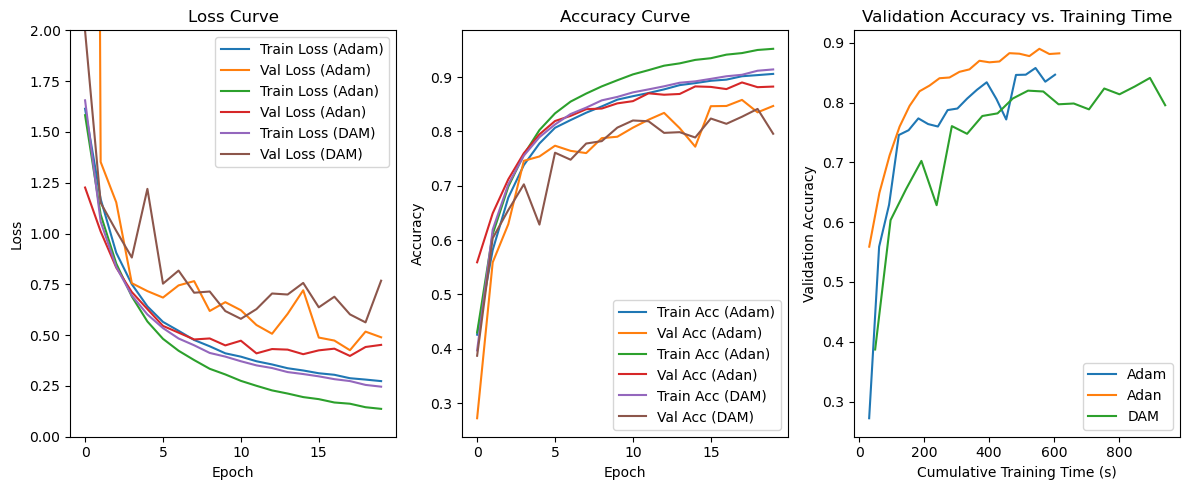

In [19]:

# 打印表格
import pandas as pd

def format_time(t):
    if t is None:
        return '/'
    else:
        return f"{t:.1f}s"

def build_acc_time_row(train_dict, val_dict):
    return [format_time(train_dict[th]) for th in acc_thresholds] + [format_time(val_dict[th]) for th in acc_thresholds]

columns = [f"Train@{int(th*100)}%" for th in acc_thresholds] + [f"Val@{int(th*100)}%" for th in acc_thresholds]
data = [
    build_acc_time_row(adam_train_acc_time, adam_val_acc_time),
    build_acc_time_row(adan_train_acc_time, adan_val_acc_time),
    build_acc_time_row(dam_train_acc_time, dam_val_acc_time),
]
index = ['Adam', 'Adan', 'DAM']
df = pd.DataFrame(data, columns=columns, index=index)
print("\nCumulative training time required to reach each accuracy threshold (unit: seconds, '/' means not reached):")
print(df)

# 画图
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.plot(train_loss_list_adam, label='Train Loss (Adam)')
plt.plot(val_loss_list_adam, label='Val Loss (Adam)')
plt.plot(train_loss_list_adan, label='Train Loss (Adan)')
plt.plot(val_loss_list_adan, label='Val Loss (Adan)')
plt.plot(train_loss_list_dam, label='Train Loss (DAM)')
plt.plot(val_loss_list_dam, label='Val Loss (DAM)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 2)
plt.legend()
plt.title('Loss Curve')

plt.subplot(1,3,2)
plt.plot(train_acc_list_adam, label='Train Acc (Adam)')
plt.plot(val_acc_list_adam, label='Val Acc (Adam)')
plt.plot(train_acc_list_adan, label='Train Acc (Adan)')
plt.plot(val_acc_list_adan, label='Val Acc (Adan)')
plt.plot(train_acc_list_dam, label='Train Acc (DAM)')
plt.plot(val_acc_list_dam, label='Val Acc (DAM)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

# 新增：累计训练时间-准确率曲线（纵轴为acc，横轴为时间）
plt.subplot(1,3,3)
plt.plot(cumulative_time_adam, val_acc_list_adam, label='Adam')
plt.plot(cumulative_time_adan, val_acc_list_adan, label='Adan')
plt.plot(cumulative_time_dam, val_acc_list_dam, label='DAM')
plt.xlabel('Cumulative Training Time (s)')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.title('Validation Accuracy vs. Training Time')

plt.tight_layout()
plt.show()